In [1]:
!pip install nibabel monai matplotlib tqdm scikit-learn streamlit

In [2]:
import os, glob
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from monai.transforms import Compose, ScaleIntensity, ToTensor
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from tqdm import tqdm


In [3]:
class BratsLazyDataset(Dataset):
    def __init__(self, subject_dirs, is_validation=False, transform=None):
        self.samples = []
        self.transform = transform
        self.is_validation = is_validation
        for subject_path in tqdm(subject_dirs):
            subject_id = os.path.basename(subject_path).replace("BraTS20_", "")
            flair = os.path.join(subject_path, f'BraTS20_{subject_id}_flair.nii')
            t1 = os.path.join(subject_path, f'BraTS20_{subject_id}_t1.nii')
            t1ce = os.path.join(subject_path, f'BraTS20_{subject_id}_t1ce.nii')
            t2 = os.path.join(subject_path, f'BraTS20_{subject_id}_t2.nii')
            if not is_validation:
                seg = os.path.join(subject_path, f'BraTS20_{subject_id}_seg.nii')
                seg_data = nib.load(seg).get_fdata()
            else:
                seg_data = None
            flair_data = nib.load(flair).get_fdata()
            for i in range(flair_data.shape[2]):
                if not is_validation and np.sum(seg_data[:, :, i]) == 0:
                    continue
                self.samples.append((flair, t1, t1ce, t2, seg if not is_validation else None, i))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        flair, t1, t1ce, t2, seg, slice_idx = self.samples[idx]
        flair = nib.load(flair).get_fdata()[:, :, slice_idx]
        t1 = nib.load(t1).get_fdata()[:, :, slice_idx]
        t1ce = nib.load(t1ce).get_fdata()[:, :, slice_idx]
        t2 = nib.load(t2).get_fdata()[:, :, slice_idx]
        image = np.stack([flair, t1, t1ce, t2], axis=0)
        if self.transform:
            image = self.transform(image)
        if not self.is_validation:
            mask = nib.load(seg).get_fdata()[:, :, slice_idx]
            if self.transform:
                mask = self.transform(mask)
            return image, mask.unsqueeze(0)
        else:
            return image


In [4]:
train_path = 'C:/Users/heman/Downloads/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
all_dirs = sorted(glob.glob(train_path + 'BraTS20_Training_*'))
train_dirs = all_dirs[:70]
val_dirs = all_dirs[1:40]

transform = Compose([ScaleIntensity(), ToTensor()])
train_ds = BratsLazyDataset(train_dirs, is_validation=False, transform=transform)
val_ds = BratsLazyDataset(val_dirs, is_validation=False, transform=transform)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=4, num_workers=0)


  0%|          | 0/70 [00:00<?, ?it/s]

100%|██████████| 39/39 [00:03<00:00, 12.12it/s]


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(
    spatial_dims=2,
    in_channels=4,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2
).to(device)

loss_fn = DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)


In [6]:
train_losses = []

for epoch in range(10):
    print(f"Epoch {epoch+1}")
    model.train()
    epoch_loss = 0
    for batch_data in tqdm(train_loader, desc="Training"):
        inputs, labels = batch_data[0].float().to(device), batch_data[1].float().to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Training Loss: {avg_loss:.4f}")


Epoch 1


Training: 100%|██████████| 1189/1189 [26:05<00:00,  1.32s/it]


Training Loss: 0.9526
Epoch 2


Training: 100%|██████████| 1189/1189 [33:45<00:00,  1.70s/it]


Training Loss: 0.9455
Epoch 3


Training: 100%|██████████| 1189/1189 [37:18<00:00,  1.88s/it]


Training Loss: 0.9363
Epoch 4


Training: 100%|██████████| 1189/1189 [28:03<00:00,  1.42s/it]


Training Loss: 0.9156
Epoch 5


Training: 100%|██████████| 1189/1189 [21:20<00:00,  1.08s/it]


Training Loss: 0.8828
Epoch 6


Training: 100%|██████████| 1189/1189 [17:28<00:00,  1.13it/s]


Training Loss: 0.8413
Epoch 7


Training: 100%|██████████| 1189/1189 [16:14<00:00,  1.22it/s]


Training Loss: 0.7928
Epoch 8


Training: 100%|██████████| 1189/1189 [16:25<00:00,  1.21it/s]


Training Loss: 0.7372
Epoch 9


Training: 100%|██████████| 1189/1189 [16:17<00:00,  1.22it/s]


Training Loss: 0.6319
Epoch 10


Training: 100%|██████████| 1189/1189 [16:24<00:00,  1.21it/s]

Training Loss: 0.5175


In [7]:
torch.save(model.state_dict(), "unet_brats20_final.pth")
print("✅ Final model saved!")


✅ Final model saved!


In [8]:
model.eval()
dice_metric = DiceMetric(include_background=True, reduction="mean")
all_preds, all_labels = [], []

with torch.no_grad():
    for batch_data in tqdm(val_loader, desc="Validating"):
        inputs, labels = batch_data[0].float().to(device), batch_data[1].float().to(device)
        outputs = model(inputs)
        preds = (outputs > 0.5).float()
        dice_metric(y_pred=preds, y=labels)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

val_dice = dice_metric.aggregate().item()
dice_metric.reset()

y_true = np.concatenate([l.flatten() for l in all_labels])
y_pred = np.concatenate([p.flatten() for p in all_preds])
y_pred = (y_pred > 0.5).astype(np.uint8)


print(f"✅ Final Validation Dice Score: {val_dice:.4f}")


Validating: 100%|██████████| 638/638 [08:35<00:00,  1.24it/s]


✅ Final Validation Dice Score: 0.4452


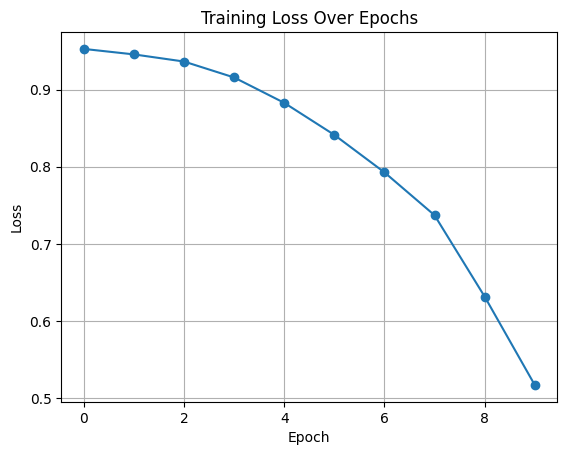

In [9]:
plt.plot(train_losses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [11]:

# 🧠 STEP 2: Region-Specific Segmentation (3-class)
from monai.networks.nets import UNet
import torch.nn as nn

model = UNet(
    spatial_dims=2,
    in_channels=4,
    out_channels=3,  # edema, core, enhancing
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2
)

loss_fn = nn.CrossEntropyLoss()

def convert_to_multiclass(mask):
    mask_out = np.zeros_like(mask, dtype=np.uint8)
    mask_out[mask == 1] = 0  # edema
    mask_out[mask == 2] = 1  # core
    mask_out[mask == 4] = 2  # enhancing
    return mask_out


In [12]:

# 🔍 STEP 3: Visual Comparison
import matplotlib.pyplot as plt

def visualize_prediction_vs_ground_truth(img, pred_mask, true_mask, slice_idx=77):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].imshow(img[:, :, slice_idx], cmap='gray')
    axs[0].set_title('Input MRI (FLAIR)')
    
    axs[1].imshow(true_mask[:, :, slice_idx], cmap='jet')
    axs[1].set_title('Ground Truth')
    
    axs[2].imshow(pred_mask[:, :, slice_idx], cmap='jet')
    axs[2].set_title('Predicted')
    
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [16]:
%pip install ipywidgets
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def show_3d_volume(volume, title="Volume", cmap='gray'):
    def plot_slice(idx):
        plt.figure(figsize=(6, 6))
        plt.imshow(volume[:, :, idx], cmap=cmap)
        plt.title(f"{title} - Slice {idx}")
        plt.axis('off')
        plt.show()

    slice_slider = widgets.IntSlider(min=0, max=volume.shape[2]-1, step=1, value=volume.shape[2]//2)
    widgets.interact(plot_slice, idx=slice_slider)


   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 12.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
